In [1]:
# -----------------------------------------------------#
# -------------------FOR TRAINING----------------------#

# Visualizing the dataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Patching the images
from patchify import patchify
from PIL import Image

# Split the data 
import splitfolders  # or import split_folders

# Load data
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Perform augmentation
import albumentations as album

# Import model, encoder weights and start training
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

# -----------------------------------------------------#
# -------------------FOR INFERENCE---------------------#
import torch
import numpy as np
from PIL import Image, ImageOps
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/home/ibrahim/anaconda3/envs/seg_pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualizing the dataset

Image and Mask filename: M-33-20-D-c-4-2.tif

Image shape: (9636, 9095, 3)



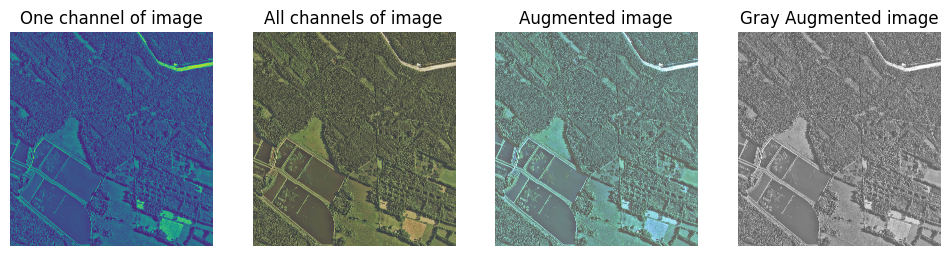


Mask shape: (9636, 9095)

Classes are:  [0 1 2 3 4]  and the counts are:  [18008335    46512 59476087  9553859   554627]



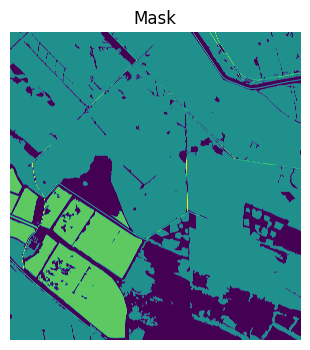

In [2]:
# Visualizing the dataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Image and Mask filename: M-33-20-D-c-4-2.tif")
print()
temp_img = cv2.imread("data/images/M-33-20-D-c-4-2.tif", 1) # 3 channels / spectral bands
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
print("Image shape:", temp_img.shape)
print()
aug_temp_img = cv2.imread("data/images/M-33-20-D-c-4-2-aug.tif", 1) # 3 channels / spectral bands
aug_temp_img = cv2.cvtColor(aug_temp_img, cv2.COLOR_BGR2RGB)
gray_aug_temp_img = cv2.imread("data/images/M-33-20-D-c-4-2-aug-gray.tif") # 3 channels / spectral bands

plt.figure(figsize=(12, 8))
plt.subplot(141)
plt.imshow(temp_img[:,:,0]);plt.axis('off')
plt.title("One channel of image")
plt.subplot(142)
plt.imshow(temp_img);plt.axis('off')
plt.title("All channels of image")
plt.subplot(143)
plt.imshow(aug_temp_img);plt.axis('off')
plt.title("Augmented image")
plt.subplot(144)
plt.imshow(gray_aug_temp_img);plt.axis('off')
plt.title("Gray Augmented image")
plt.show()
print()


temp_mask = cv2.imread("data/masks/M-33-20-D-c-4-2.tif") # 3 channels but all same. Can also read with cv2.imread(path, 0) to get only one channel.
print("Mask shape:", temp_mask[:,:,0].shape)
print()
classes, count = np.unique(temp_mask[:,:,0], return_counts=True) # Visualize only one channel. All chanels are identical.
print("Classes are: ", classes, " and the counts are: ", count)
print()

plt.figure(figsize=(6, 4))
plt.imshow(temp_mask[:,:,0]);plt.axis('off')
plt.title("Mask")
plt.show()
print()

# Model Training

In [3]:
# Patching the images
from patchify import patchify
from PIL import Image

root_directory = "data"

img_dir = os.path.join(root_directory, "images")
mask_dir = os.path.join(root_directory, "masks")

patch_size = 512

patches_img_dir = os.path.join(f"patches_{patch_size}", "images")
patches_img_dir = os.path.join(root_directory, patches_img_dir)
os.makedirs(patches_img_dir, exist_ok=True)
patches_mask_dir = os.path.join(f"patches_{patch_size}", "masks")
patches_mask_dir = os.path.join(root_directory, patches_mask_dir)
os.makedirs(patches_mask_dir, exist_ok=True)


def patching(data_dir, patches_dir, patch_size):
  for filename in os.listdir(data_dir):
    if filename.endswith('.tif'):
      img = cv2.imread(os.path.join(data_dir, filename), 1)
      max_height = (img.shape[0] // patch_size) * patch_size
      max_width = (img.shape[1] // patch_size) * patch_size
      img = img[0:max_height, 0:max_width]
      print(f"Patchifying {filename}...")
      patches = patchify(img, (patch_size, patch_size, 3), step = patch_size)  # non-overlapping
      print("Patches shape:", patches.shape)
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          single_patch = patches[i, j, 0, :, :] # the 0 is an extra unncessary dimension added by patchify for multiple channels scenario
          cv2.imwrite(os.path.join(patches_dir, filename.replace(".tif", f"_patch_{i}_{j}.tif")), single_patch)

print()
print("Dividing images into patches...")
patching(img_dir, patches_img_dir, patch_size)
print("Dividing images into patches completed successfull!")

print()
print("Dividing masks into patches...")
patching(mask_dir, patches_mask_dir, patch_size)
print("Dividing masks into patches completed successfull!")


Dividing images into patches...
Patchifying M-34-65-D-a-4-4-aug-gray.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying M-34-51-C-b-2-1-aug-gray.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying M-34-65-D-a-4-4.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying M-34-6-A-d-2-2-aug-gray.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying M-34-5-D-d-4-2-aug-gray.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying N-34-97-C-b-1-2.tif...
Patches shape: (9, 8, 1, 512, 512, 3)
Patchifying M-33-48-A-c-4-4.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying N-34-106-A-b-3-4-aug-gray.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying M-34-65-D-c-4-2-aug.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying M-33-20-D-c-4-2-aug-gray.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying N-33-139-C-d-2-4-aug.tif...
Patches shape: (18, 17, 1, 512, 512, 3)
Patchifying M-34-68-B-a-1-3.tif...
Patches shape: (18, 18, 1, 512, 512, 3)
Patchif

In [4]:
print(len(os.listdir(patches_img_dir)))
print(len(os.listdir(patches_mask_dir)))

32022
32022


## Data Preprocessing - Removing "Useless" Data

In [5]:
def discard_useless_patches(patches_img_dir, patches_mask_dir):
  for filename in os.listdir(patches_mask_dir):
    img_path = os.path.join(patches_img_dir, filename)
    mask_path = os.path.join(patches_mask_dir, filename)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    classes, count = np.unique(mask, return_counts = True)
    # If background class occupies more than 95% of the image, discard the image and mask
    if (count[0] / count.sum()) > 0.95:
      os.remove(img_path)
      os.remove(mask_path)

discard_useless_patches(patches_img_dir, patches_mask_dir)

In [6]:
print(len(os.listdir(patches_img_dir)))
print(len(os.listdir(patches_mask_dir)))

21159
21159


### Train-Val Split

In [7]:
import splitfolders  # or import split_folders

input_folder = patches_img_dir.strip("images")
print(input_folder)
output_folder = os.path.join(root_directory, "train_val_test")
print(output_folder)

os.makedirs(output_folder, exist_ok=True)

# Split with a ratio.
# To split into training, validation, and testing set, set a tuple to `ratio`, i.e, `(.8, .1, .1)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None, move=False) # splitting in training and validation only

train_dir = os.path.join(output_folder, "train")
val_dir = os.path.join(output_folder, "val")
# test_dir = os.path.join(output_folder, "test")

data/patches_512/
data/train_val_test


Copying files: 42318 files [00:07, 6021.01 files/s] 


In [8]:
x_train_dir = os.path.join(train_dir, "images")
y_train_dir = os.path.join(train_dir, "masks")

x_val_dir = os.path.join(val_dir, "images")
y_val_dir = os.path.join(val_dir, "masks")

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):

    """
    landcover.ai dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)
    """

    CLASSES = ['background', 'building', 'woodland', 'water', 'road']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255
        mask = cv2.imread(self.masks[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

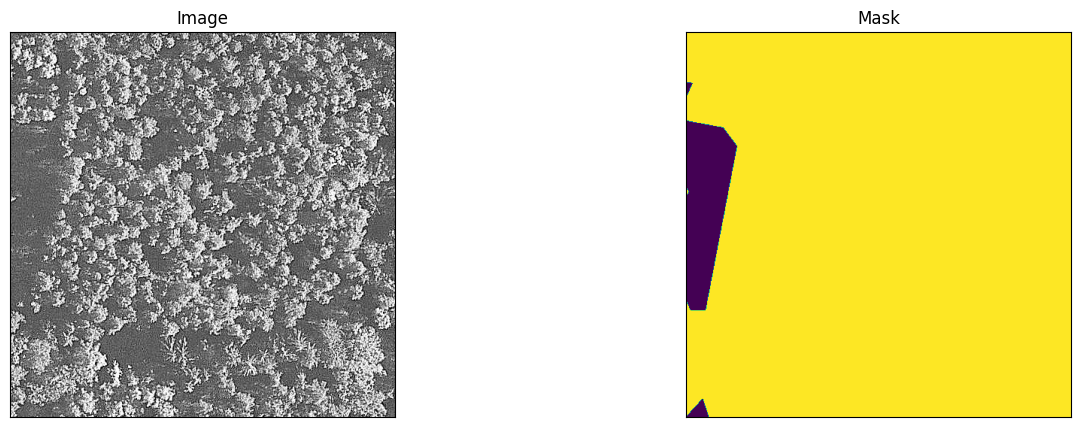

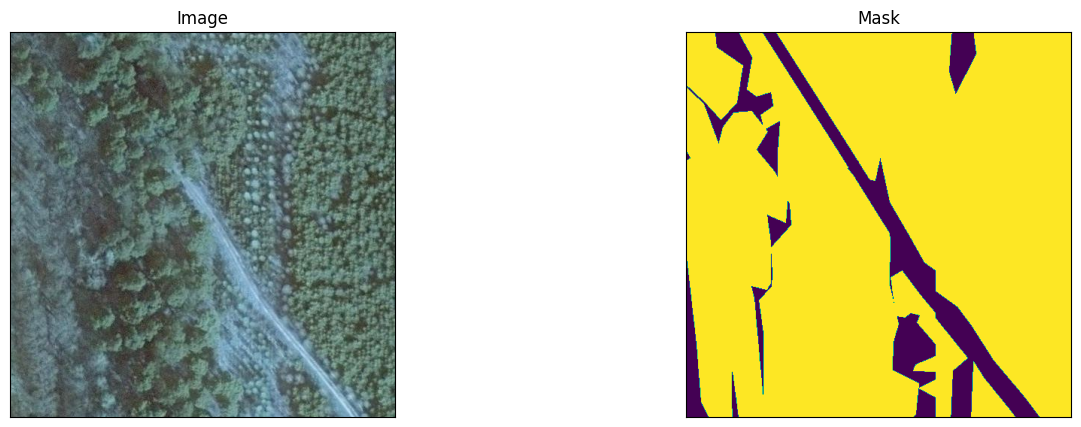

In [11]:
# Visualizing all classes in the mask
dataset = SegmentationDataset(x_train_dir, y_train_dir, classes=['background', 'building', 'woodland', 'water', 'road'])
image, mask = dataset[4] # get some sample
visualize(
    image = image,
    # Convert the predicted one-hot encoded mask back to normal
    mask = np.argmax(mask, axis=2)
)

# Visualizing selected classes in the mask
dataset = SegmentationDataset(x_train_dir, y_train_dir, classes=['background', 'water', 'woodland'])
image, mask = dataset[16] # get some sample
visualize(
    image = image,
    # Convert the predicted one-hot encoded mask back to normal
    mask = np.argmax(mask, axis=2)
)

In [12]:
import albumentations as album

# Apply augmentation on train data
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)

# Rearrange the dimensions and read as float32
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# Preprocess the image and mask 
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albummentations.Compose

    """
    _transform = [
        album.Lambda(image=preprocessing_fn),
        album.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return album.Compose(_transform)

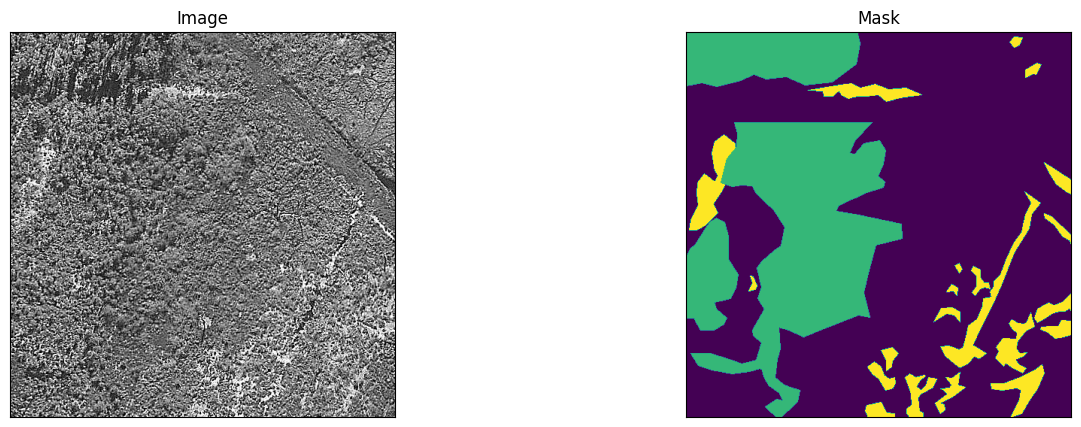

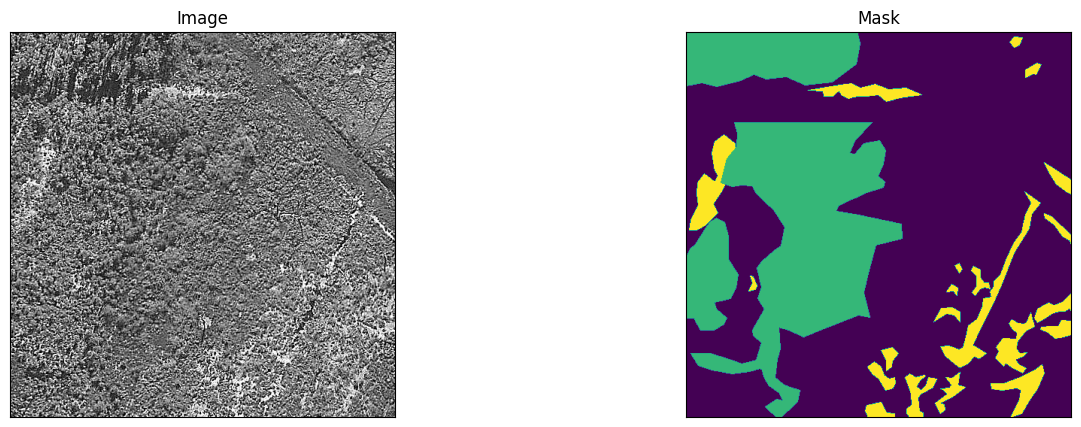

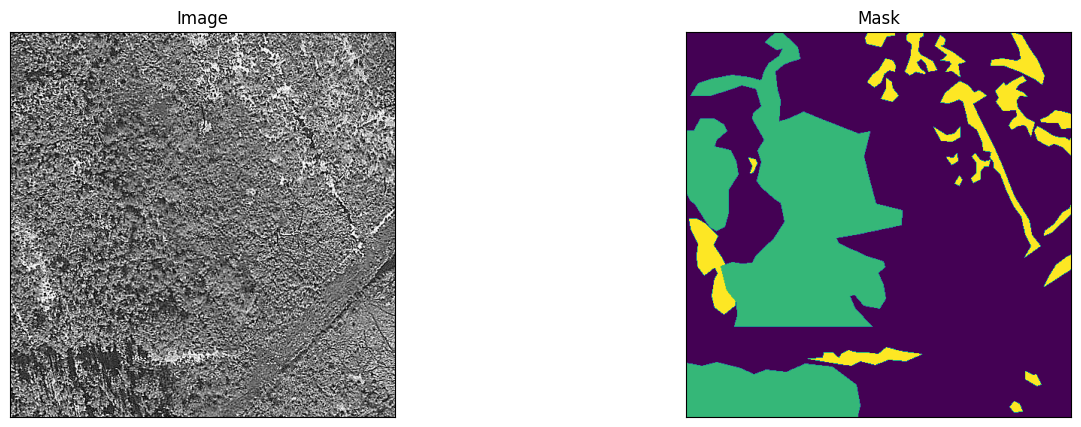

In [14]:
# Visualize resulted augmented images and masks

augmented_dataset = SegmentationDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['background', 'building', 'woodland', 'water', 'road'],
)

# Same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[5123]
    visualize(image=image, mask=np.argmax(mask, axis=2))

In [15]:
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

BATCH_SIZE = 16
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'building', 'woodland', 'water']   # not training on 'road' class since it's instances in the data is too less
ACTIVATION = 'softmax2d'    # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
EPOCHS = 50

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/ibrahim/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:03<00:00, 6.12MB/s]


In [16]:
train_dataset = SegmentationDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

val_dataset = SegmentationDataset(
    x_val_dir,
    y_val_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [17]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0003),
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [18]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [20]:
max_score = 0

for i in range(0, EPOCHS):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f'/home/ibrahim/Documents/Ibrahim_/July/lulc_dl/models/landcover_unet_{ENCODER}_epochs{i}_patch{patch_size}_batch{BATCH_SIZE}.pth')
        print('Model saved!')

    scheduler.step(valid_logs['dice_loss'])


Epoch: 0
valid: 100%|██████████| 4232/4232 [02:40<00:00, 26.41it/s, dice_loss - 0.08656, iou_score - 0.85]  
Model saved!

Epoch: 1
valid: 100%|██████████| 4232/4232 [02:38<00:00, 26.75it/s, dice_loss - 0.08365, iou_score - 0.8535]
Model saved!

Epoch: 2
valid: 100%|██████████| 4232/4232 [02:38<00:00, 26.65it/s, dice_loss - 0.07359, iou_score - 0.8687]
Model saved!

Epoch: 3
valid: 100%|██████████| 4232/4232 [02:41<00:00, 26.25it/s, dice_loss - 0.0709, iou_score - 0.8731] 
Model saved!

Epoch: 4
valid: 100%|██████████| 4232/4232 [02:39<00:00, 26.56it/s, dice_loss - 0.06799, iou_score - 0.8774]
Model saved!

Epoch: 5
valid: 100%|██████████| 4232/4232 [02:33<00:00, 27.62it/s, dice_loss - 0.07008, iou_score - 0.8741]

Epoch: 6
valid: 100%|██████████| 4232/4232 [02:34<00:00, 27.45it/s, dice_loss - 0.06617, iou_score - 0.8809]
Model saved!

Epoch: 7
valid: 100%|██████████| 4232/4232 [02:33<00:00, 27.56it/s, dice_loss - 0.06263, iou_score - 0.8863]
Model saved!

Epoch: 8
valid: 100%|███████

---
### The End